In [1]:
# Loading Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression, LinearRegression

In [3]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, ConvLSTM2D, LSTM, Activation

In [4]:
# Labelling Columns with appropriate names
cols = ['Unit', 'Cycle', 'Setting1', 'Setting2', 'Setting3', 'FanInletTemp',
        'LPCOutletTemp', 'HPCOutletTemp', 'LPTOutletTemp', 'FanInletPres', 
        'BypassDuctPres', 'TotalHPCOutletPres', 'PhysFanSpeed', 'PhysCoreSpeed', 
        'EnginePresRatio', 'StaticHPCOutletPres', 'FuelFlowRatio', 'CorrFanSpeed',
        'CorrCoreSpeed', 'BypassRatio', 'BurnerFuelAirRatio', 'BleedEnthalpy',
        'DemandFanSpeed', 'DemandCorrFanSpeed', 'HPTCoolantBleed', 'LPTCoolantBleed']

In [5]:
df = pd.read_table("CMaps/train_FD001.txt", sep = " ", header = None)
df = df.drop([26,27], axis = 1)
df.columns = cols

In [6]:
# Selecting attributes with variance

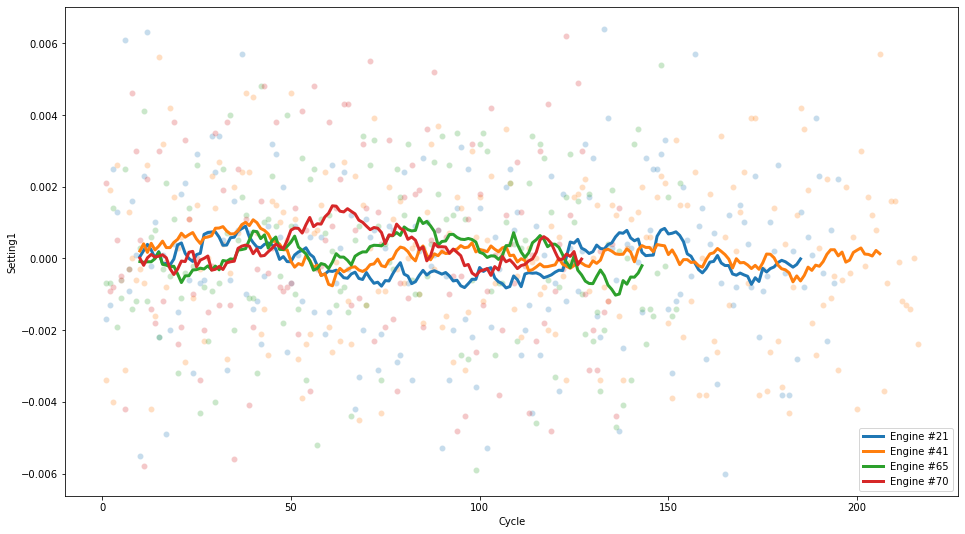

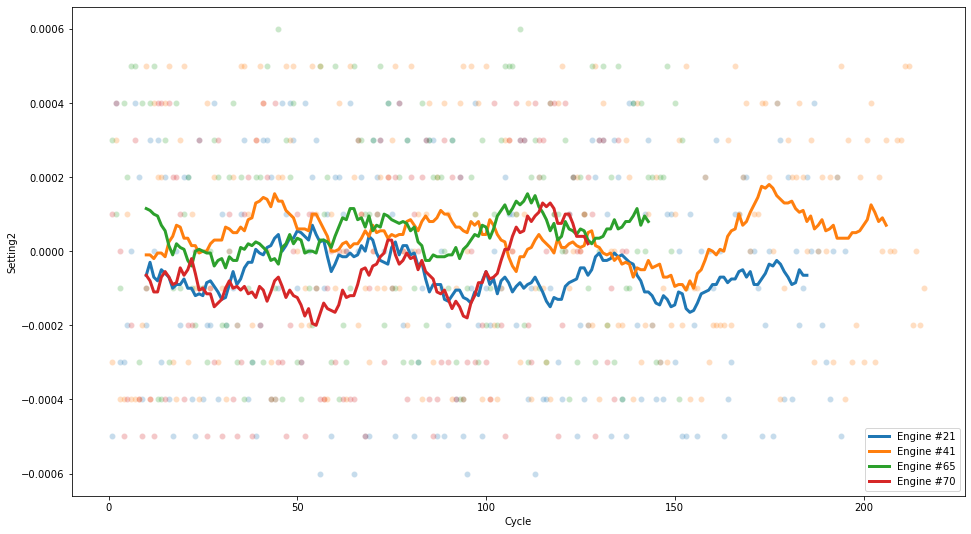

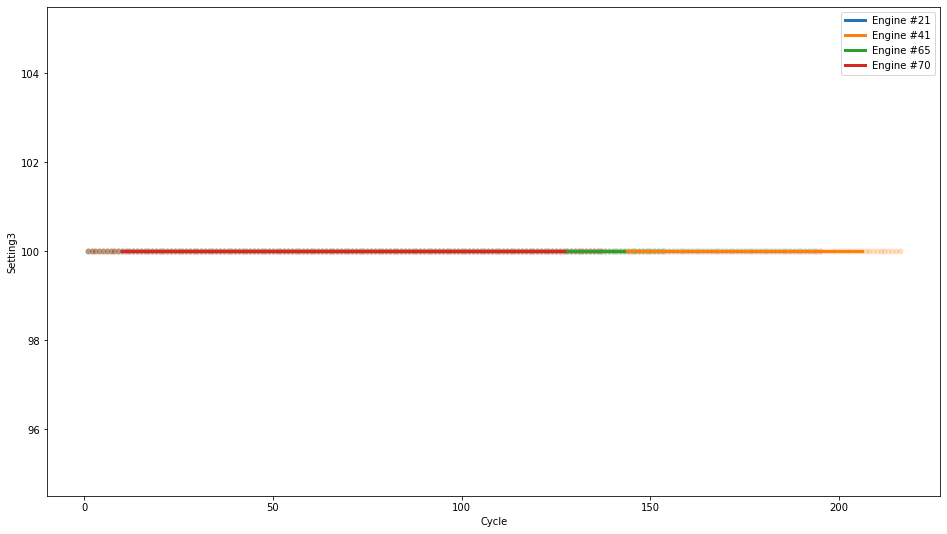

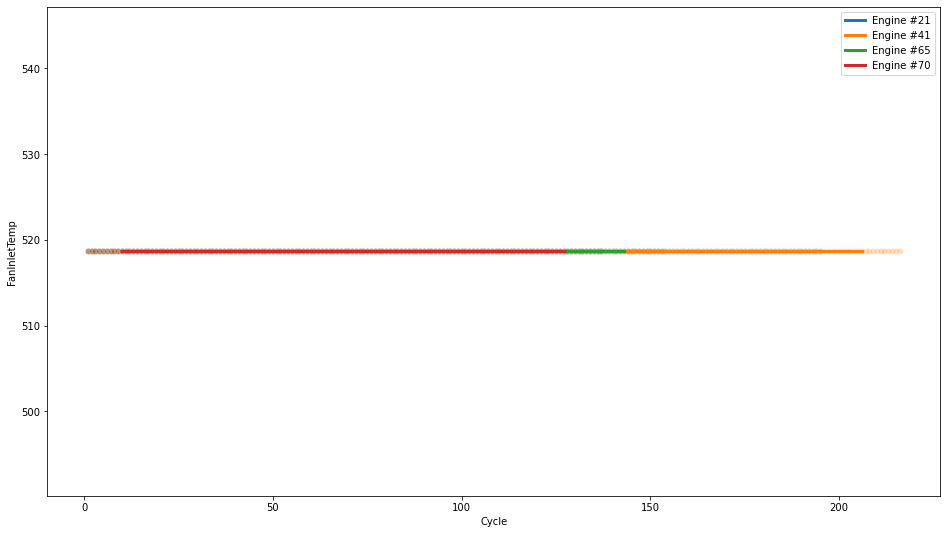

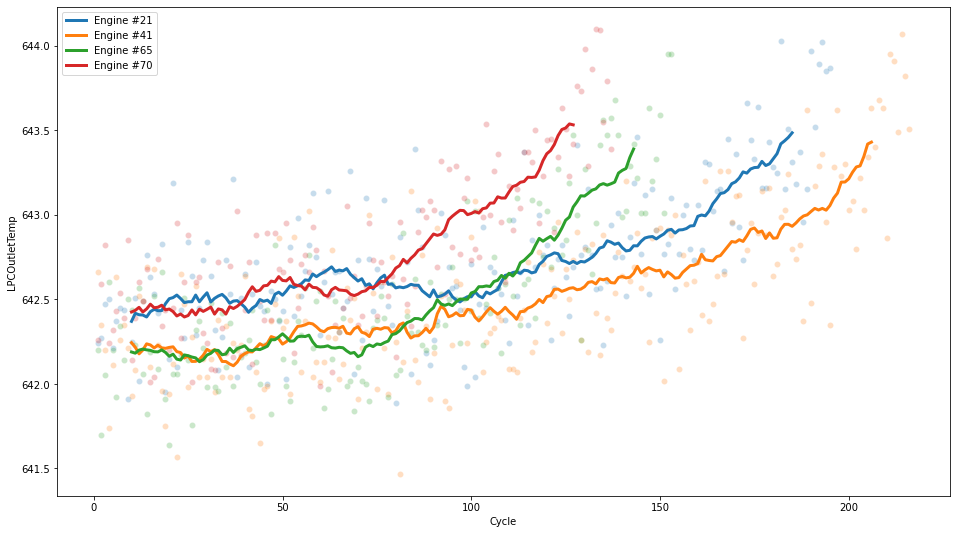

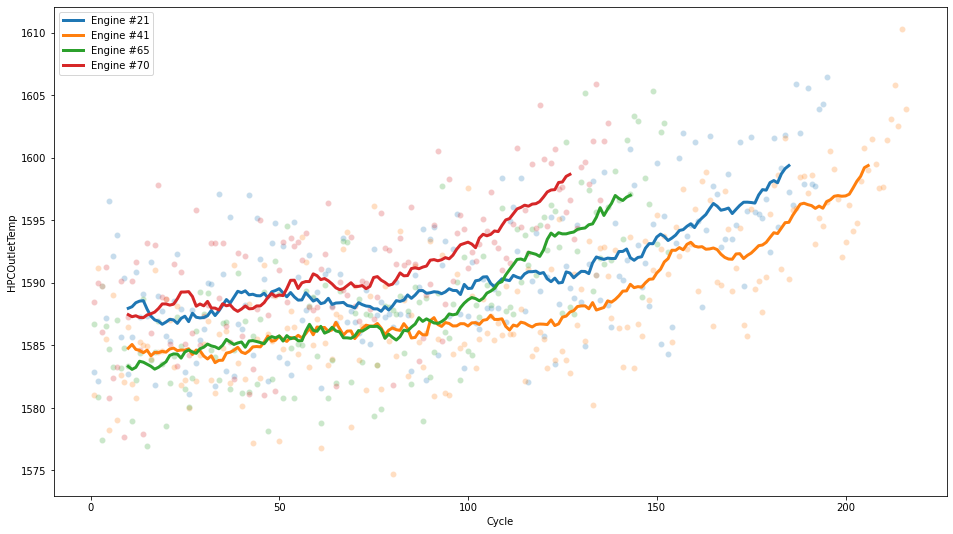

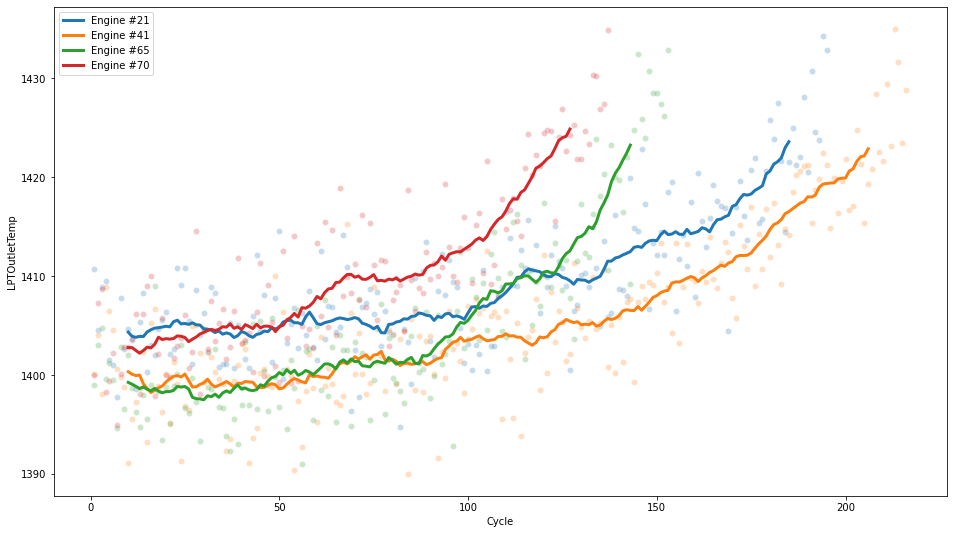

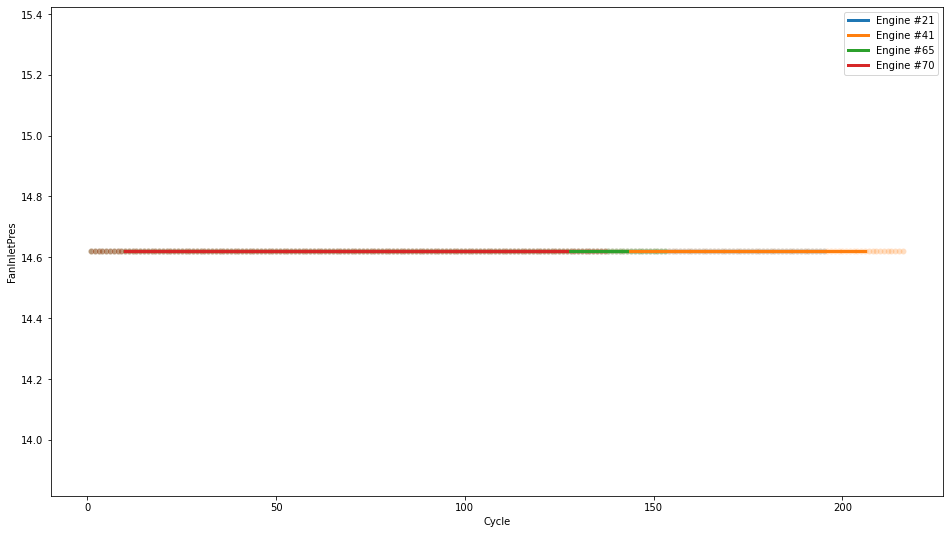

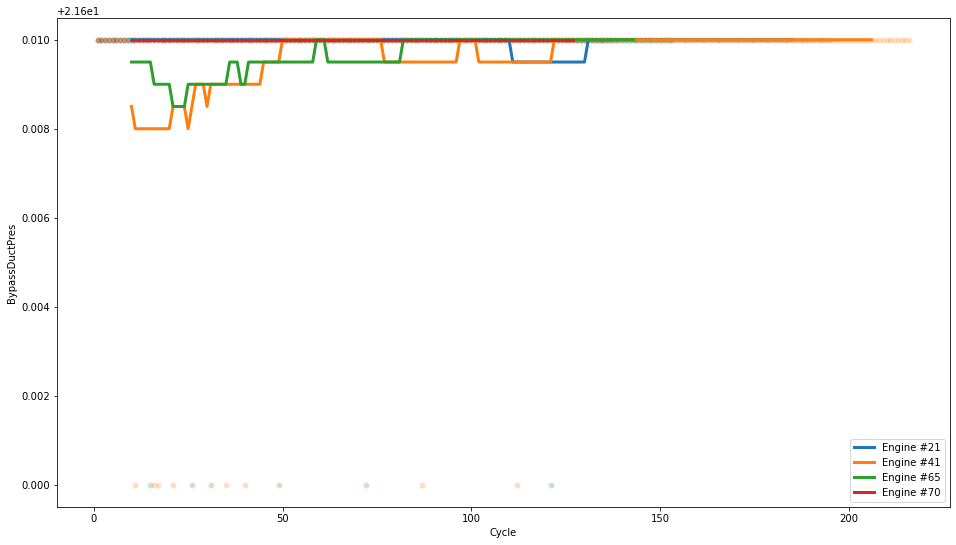

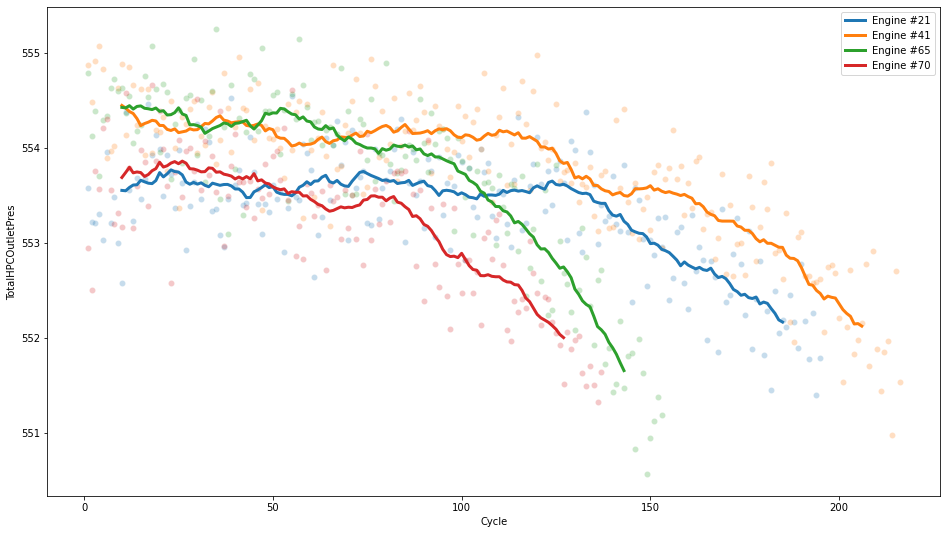

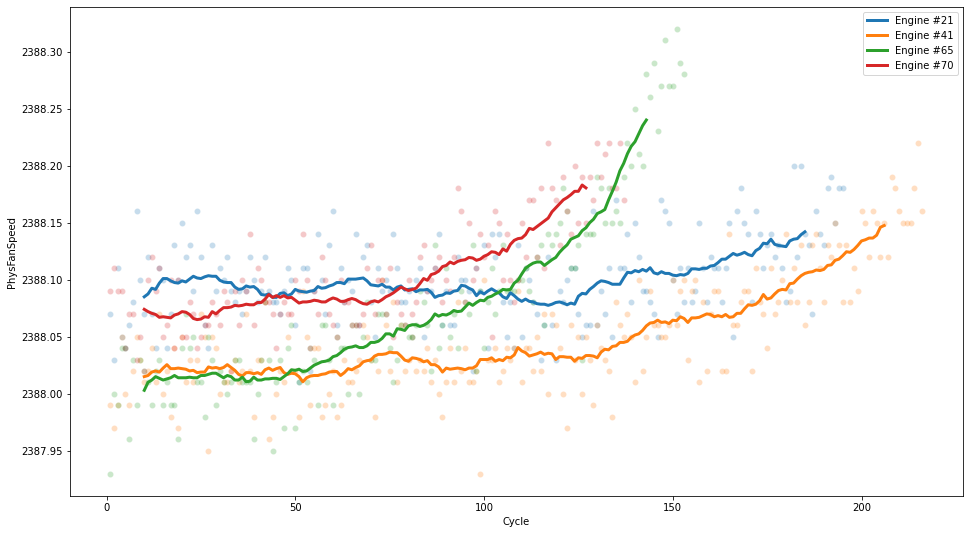

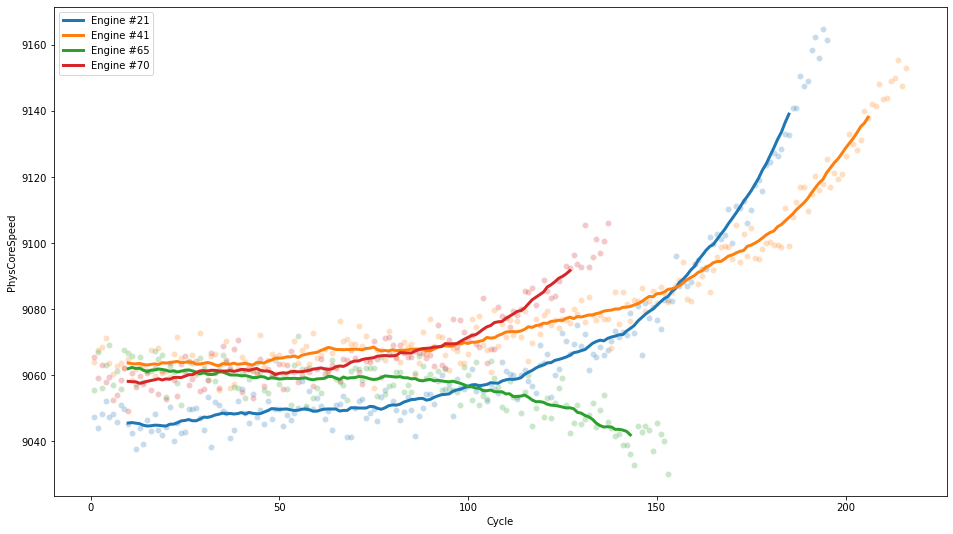

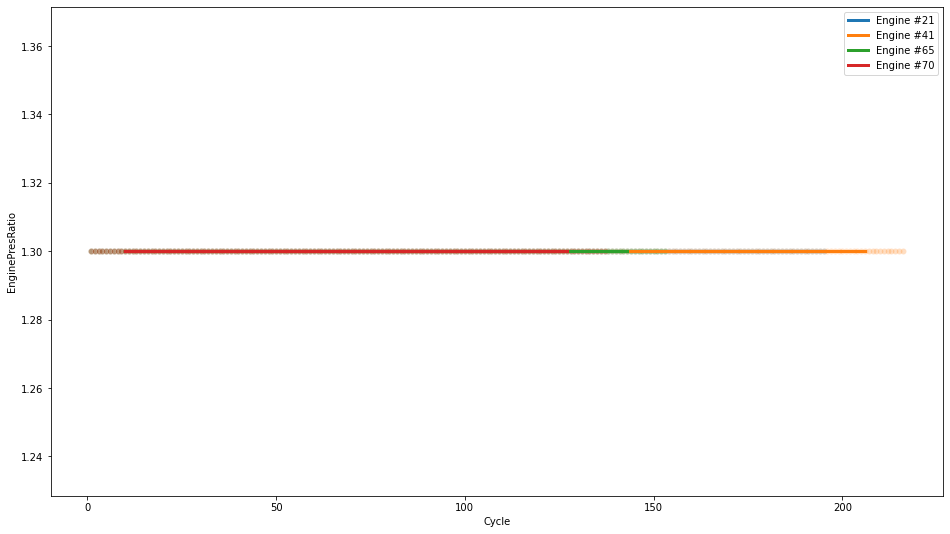

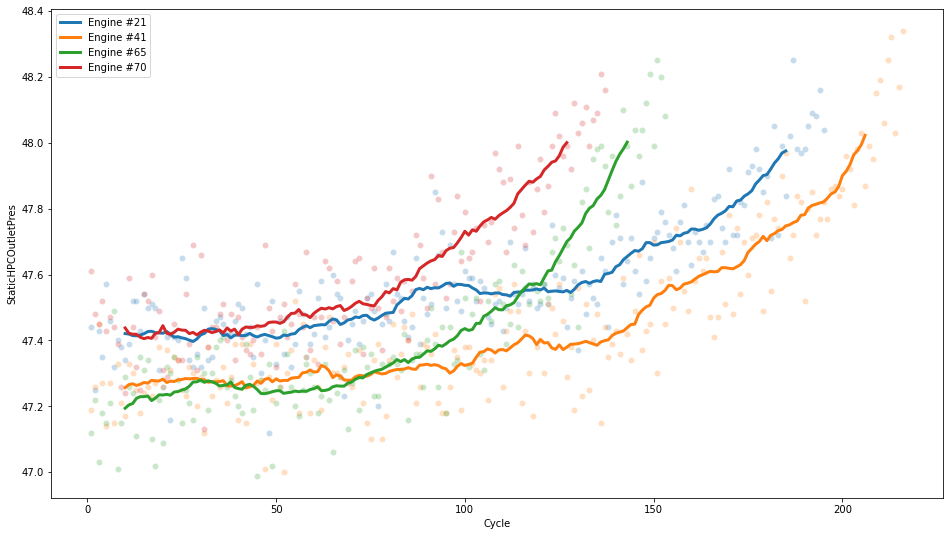

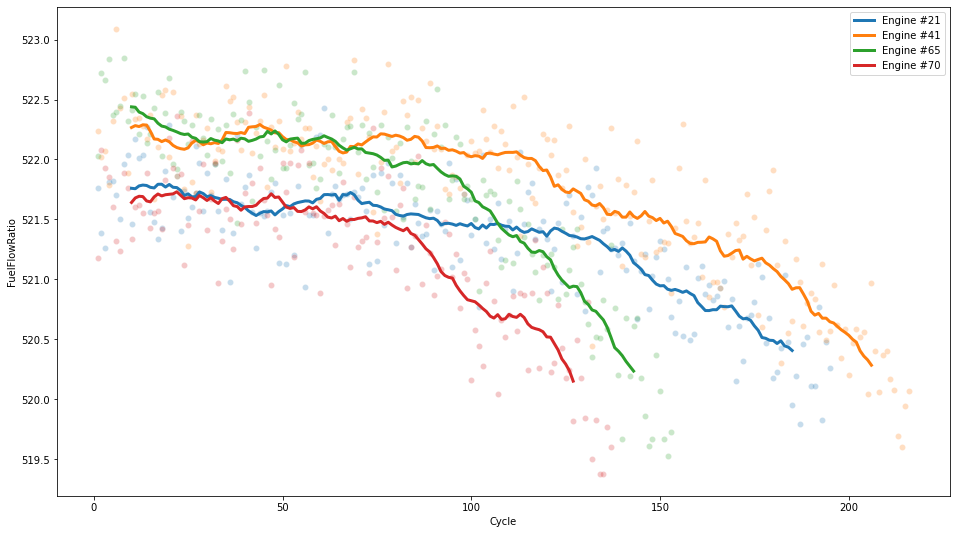

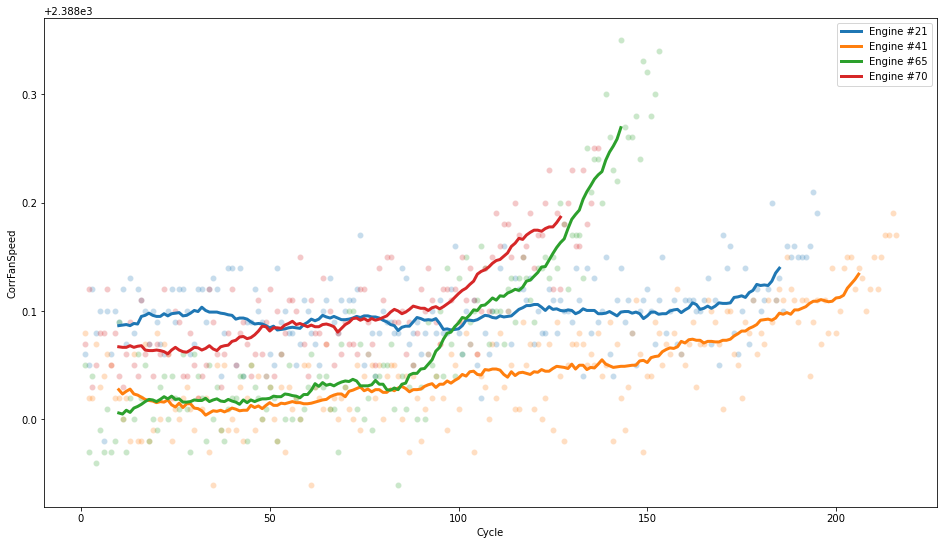

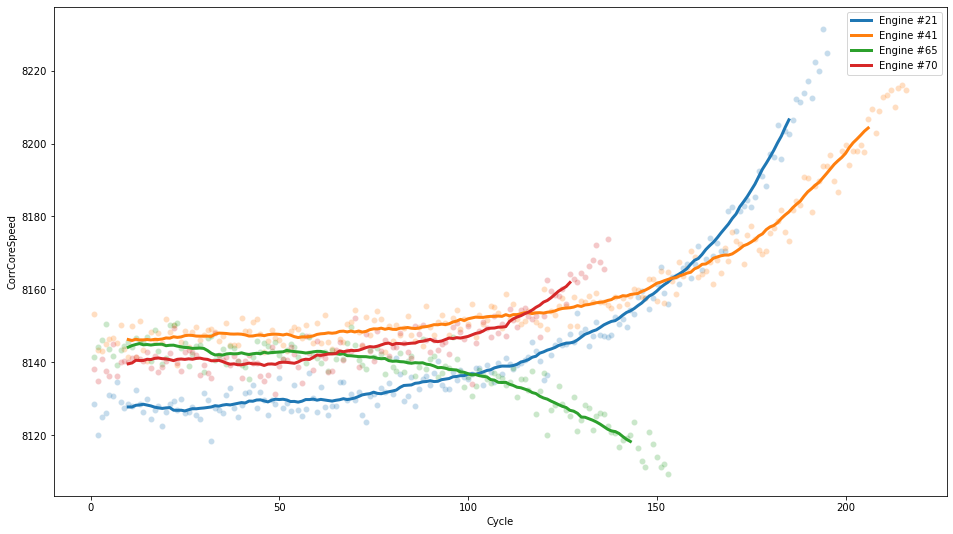

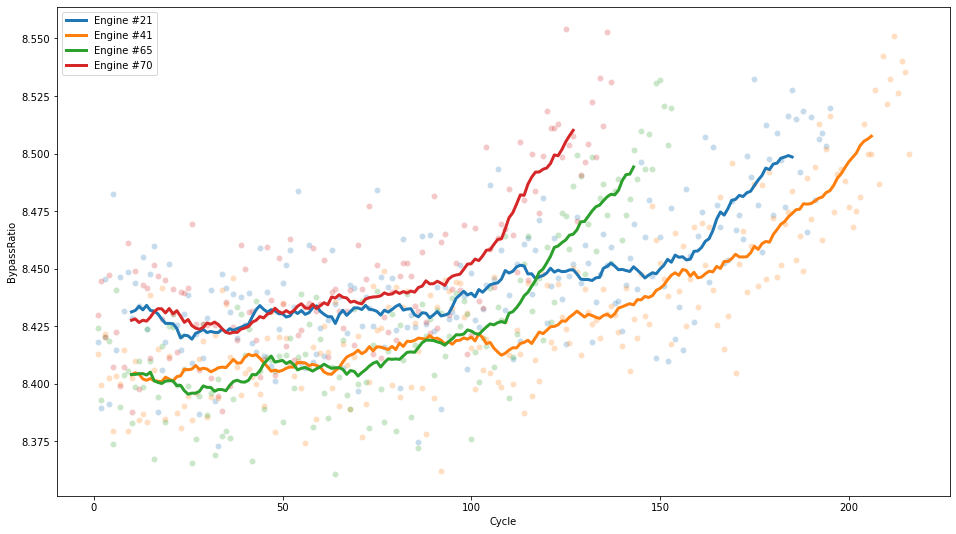

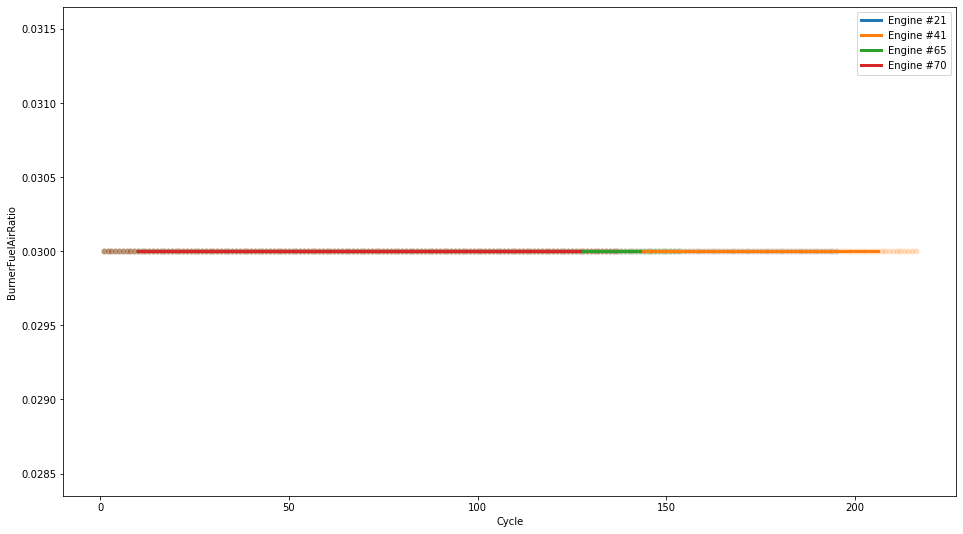

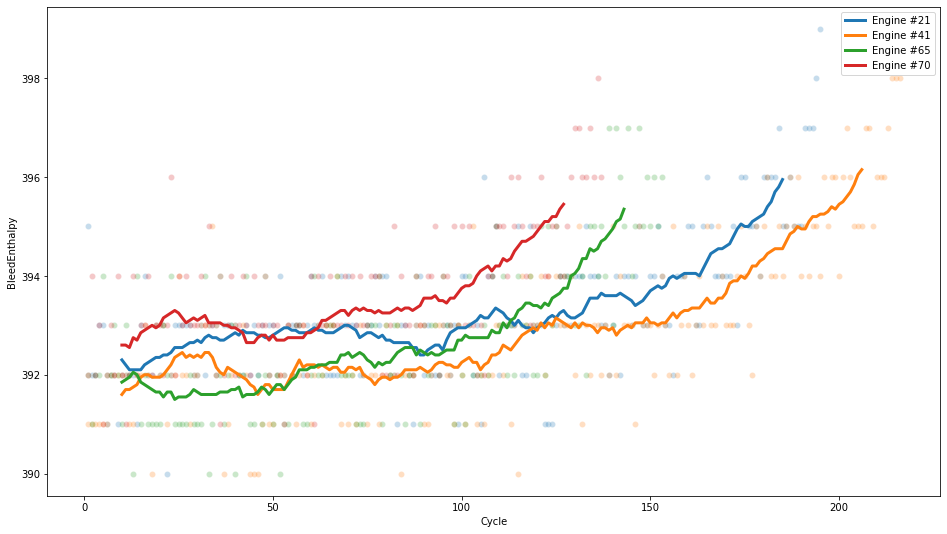

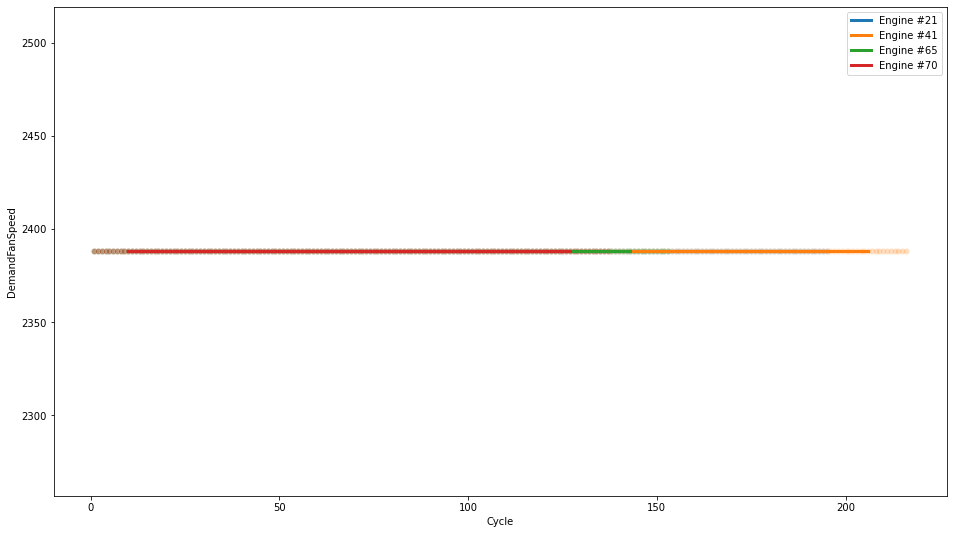

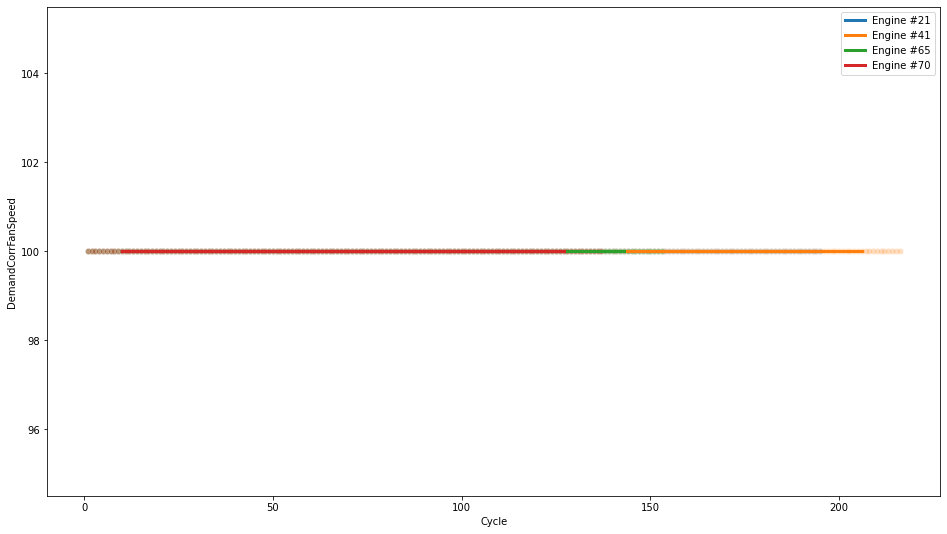

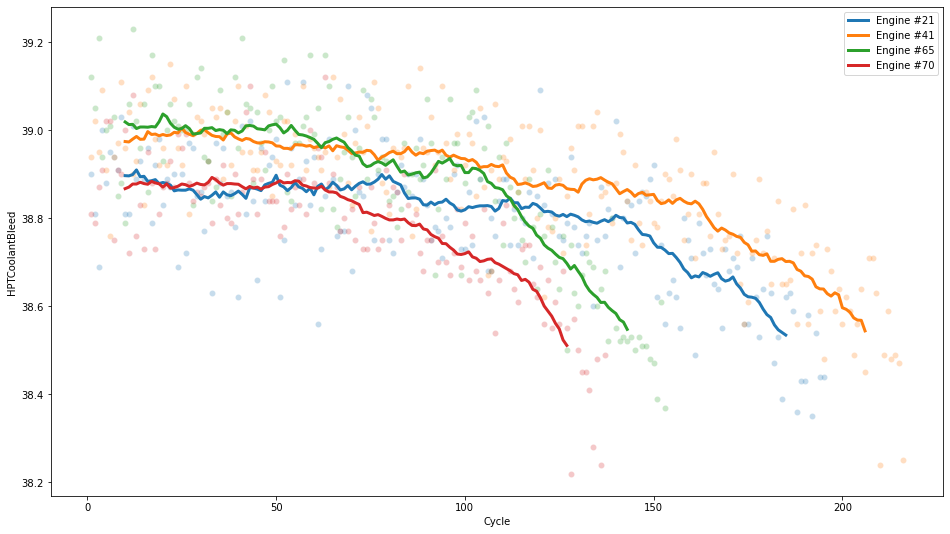

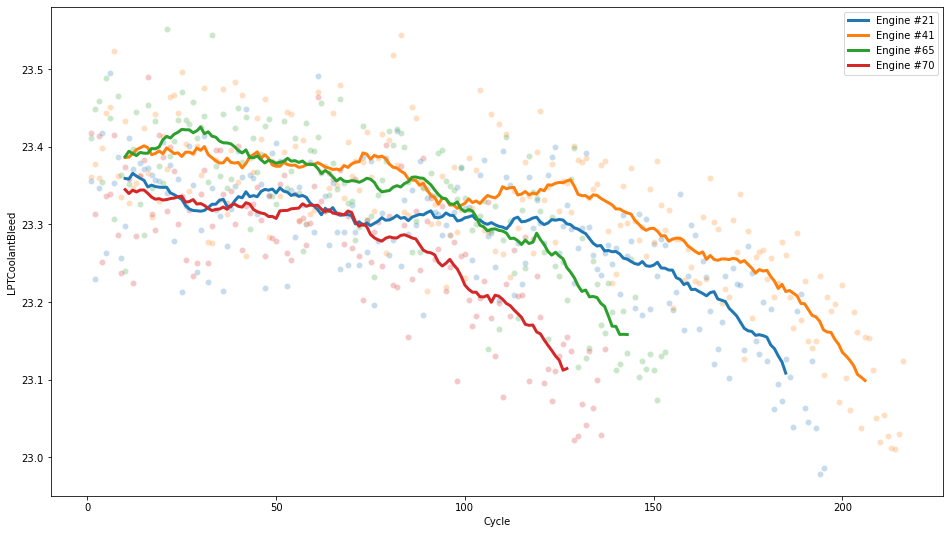

In [7]:
df_sample = df[df['Unit'].isin(np.random.choice(df['Unit'].unique(),6))}

for col in df_sample.columns[2:]:
    plt.figure(figsize=(16,9))
    for unit in df_sample['Unit'].unique():
        tmp = df_sample[df_sample['Unit'] == unit]
        sns.scatterplot(x = tmp['Cycle'], y = tmp[col], alpha = 0.25)
        sns.lineplot(x = tmp['Cycle']-10, y = tmp[col].rolling(window=20).mean(), linewidth = 3, label = f'Engine #{unit}')
    plt.show()

In [8]:
df

,Unit,Cycle,Setting1,Setting2,Setting3,FanInletTemp,LPCOutletTemp,HPCOutletTemp,LPTOutletTemp,FanInletPres,...,FuelFlowRatio,CorrFanSpeed,CorrCoreSpeed,BypassRatio,BurnerFuelAirRatio,BleedEnthalpy,DemandFanSpeed,DemandCorrFanSpeed,HPTCoolantBleed,LPTCoolantBleed
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,519.49,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,519.68,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,520.01,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,519.67,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640


In [9]:
df_new = pd.DataFrame()
for unit in df['Unit'].unique():
    df_tmp = df[df['Unit'] == unit].reset_index(False)
    for i in ['FanInletTemp','LPCOutletTemp', 'HPCOutletTemp', 'LPTOutletTemp', 'FanInletPres', 
              'BypassDuctPres', 'TotalHPCOutletPres', 'PhysFanSpeed', 'PhysCoreSpeed', 
              'EnginePresRatio', 'StaticHPCOutletPres', 'FuelFlowRatio', 'CorrFanSpeed',
              'CorrCoreSpeed', 'BypassRatio', 'BurnerFuelAirRatio', 'BleedEnthalpy',
              'DemandFanSpeed', 'DemandCorrFanSpeed', 'HPTCoolantBleed', 'LPTCoolantBleed']:
        df_tmp[f'{i}_MA'] = df_tmp[i].rolling(window=20).mean()
    df_new = pd.concat([df_new,df_tmp])
df_new = df_new.dropna()
df_new.drop(['index'], axis = 1, inplace=True)

df = df_new
df

,Unit,Cycle,Setting1,Setting2,Setting3,FanInletTemp,LPCOutletTemp,HPCOutletTemp,LPTOutletTemp,FanInletPres,...,FuelFlowRatio_MA,CorrFanSpeed_MA,CorrCoreSpeed_MA,BypassRatio_MA,BurnerFuelAirRatio_MA,BleedEnthalpy_MA,DemandFanSpeed_MA,DemandCorrFanSpeed_MA,HPTCoolantBleed_MA,LPTCoolantBleed_MA
19,1,20,-0.0037,0.0001,100.0,518.67,643.04,1581.11,1405.23,14.62,...,521.9890,2388.0430,8132.6075,8.412345,0.03,391.85,2388.0,100.0,38.9720,23.385150
20,1,21,-0.0012,0.0001,100.0,518.67,642.37,1586.07,1398.13,14.62,...,522.0270,2388.0460,8132.3775,8.411615,0.03,391.85,2388.0,100.0,38.9735,23.379705
21,1,22,0.0002,0.0000,100.0,518.67,642.77,1592.93,1400.57,14.62,...,522.0130,2388.0440,8132.3235,8.410195,0.03,391.85,2388.0,100.0,38.9695,23.377485
22,1,23,0.0034,-0.0003,100.0,518.67,642.14,1588.19,1394.75,14.62,...,521.9680,2388.0450,8132.0570,8.410505,0.03,391.95,2388.0,100.0,38.9690,23.383085
23,1,24,-0.0010,0.0003,100.0,518.67,642.38,1590.83,1398.81,14.62,...,521.9315,2388.0425,8132.0595,8.411550,0.03,391.95,2388.0,100.0,38.9750,23.382870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,520.1090,2388.2230,8141.0560,8.506575,0.03,395.65,2388.0,100.0,38.4905,23.120945
196,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,520.0790,2388.2250,8140.7335,8.506605,0.03,395.65,2388.0,100.0,38.4755,23.127155
197,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,520.0890,2388.2290,8140.6935,8.510455,0.03,395.80,2388.0,100.0,38.4700,23.112560
198,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,520.0545,2388.2310,8140.7290,8.511310,0.03,395.75,2388.0,100.0,38.4535,23.107335


In [10]:
rul = pd.DataFrame(df.groupby('Unit')['Cycle'].max()).reset_index(False)
rul.columns = ['Unit','Max_Cycles']
df = df.merge(rul, on = ['Unit'])
df['RUL'] = df['Max_Cycles'] - df['Cycle']
df.drop(['Max_Cycles'], axis = 1, inplace = True)
df = df.dropna(axis = 0)

In [11]:
df

,Unit,Cycle,Setting1,Setting2,Setting3,FanInletTemp,LPCOutletTemp,HPCOutletTemp,LPTOutletTemp,FanInletPres,...,CorrFanSpeed_MA,CorrCoreSpeed_MA,BypassRatio_MA,BurnerFuelAirRatio_MA,BleedEnthalpy_MA,DemandFanSpeed_MA,DemandCorrFanSpeed_MA,HPTCoolantBleed_MA,LPTCoolantBleed_MA,RUL
0,1,20,-0.0037,0.0001,100.0,518.67,643.04,1581.11,1405.23,14.62,...,2388.0430,8132.6075,8.412345,0.03,391.85,2388.0,100.0,38.9720,23.385150,172
1,1,21,-0.0012,0.0001,100.0,518.67,642.37,1586.07,1398.13,14.62,...,2388.0460,8132.3775,8.411615,0.03,391.85,2388.0,100.0,38.9735,23.379705,171
2,1,22,0.0002,0.0000,100.0,518.67,642.77,1592.93,1400.57,14.62,...,2388.0440,8132.3235,8.410195,0.03,391.85,2388.0,100.0,38.9695,23.377485,170
3,1,23,0.0034,-0.0003,100.0,518.67,642.14,1588.19,1394.75,14.62,...,2388.0450,8132.0570,8.410505,0.03,391.95,2388.0,100.0,38.9690,23.383085,169
4,1,24,-0.0010,0.0003,100.0,518.67,642.38,1590.83,1398.81,14.62,...,2388.0425,8132.0595,8.411550,0.03,391.95,2388.0,100.0,38.9750,23.382870,168
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18726,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,2388.2230,8141.0560,8.506575,0.03,395.65,2388.0,100.0,38.4905,23.120945,4
18727,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,2388.2250,8140.7335,8.506605,0.03,395.65,2388.0,100.0,38.4755,23.127155,3
18728,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,2388.2290,8140.6935,8.510455,0.03,395.80,2388.0,100.0,38.4700,23.112560,2
18729,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,2388.2310,8140.7290,8.511310,0.03,395.75,2388.0,100.0,38.4535,23.107335,1


<AxesSubplot:xlabel='Cycle', ylabel='CorrCoreSpeed'>

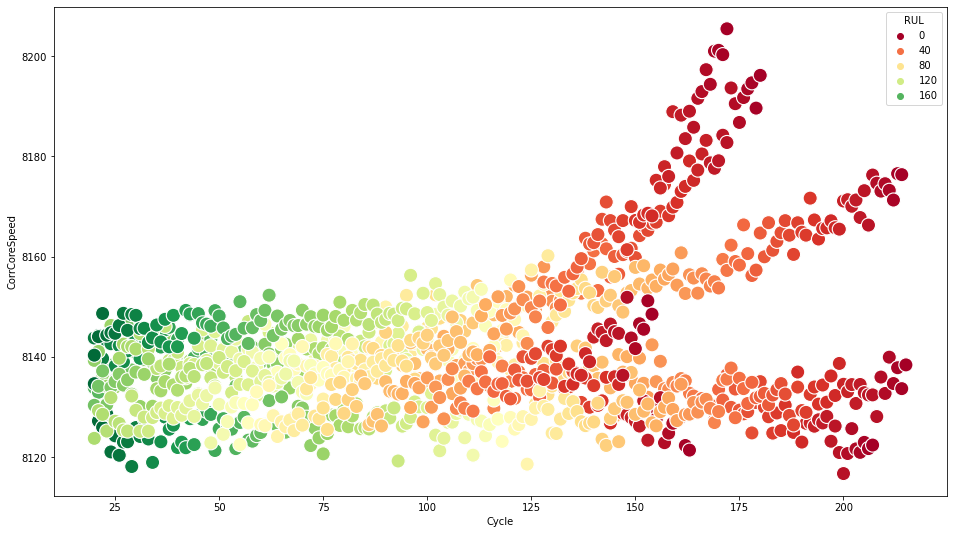

In [12]:
plt.figure(figsize=(16,9))

df_temp = df[df['Unit'].isin(np.random.choice(df['Unit'].unique(), 9))]


sns.scatterplot(x = df_temp['Cycle'], y = df_temp['CorrCoreSpeed'], hue = df_temp['RUL'], s = 200, palette='RdYlGn')

<AxesSubplot:xlabel='RUL', ylabel='BypassRatio'>

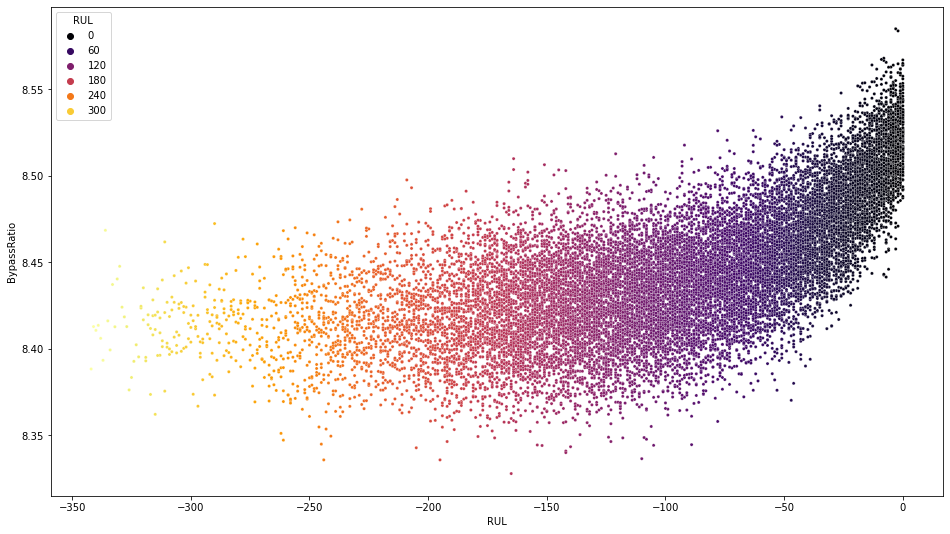

In [43]:
plt.figure(figsize=(16,9))
sns.scatterplot(x = -df['RUL'], y = df['BypassRatio'], hue = df['RUL'], s = 10, palette='inferno')

Text(0.5, 1.0, 'CorrCoreSpeed per Cycle for all 100 Engines (colored by RUL)')

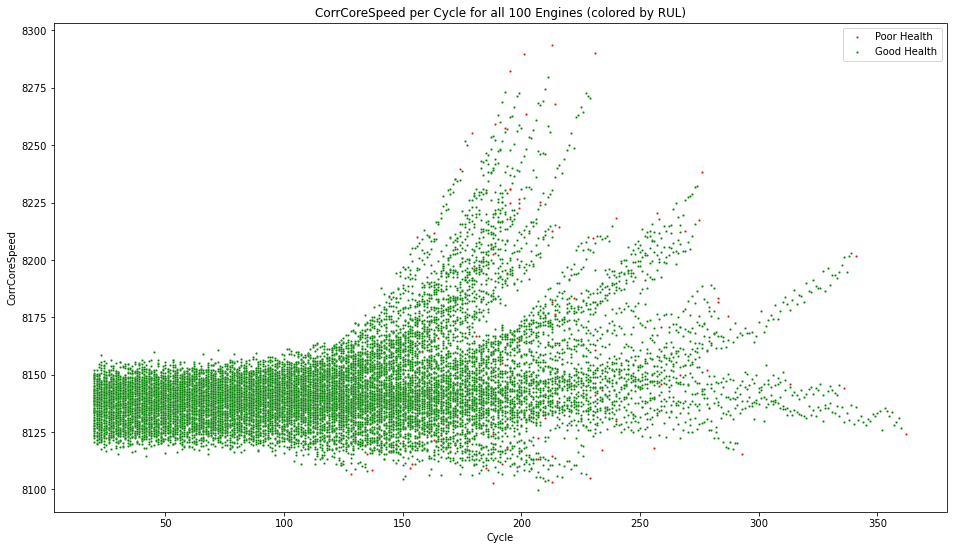

In [14]:
plt.figure(figsize=(16,9))
sns.scatterplot(x = df[df['RUL'] <= 0]['Cycle'], 
                y = df[df['RUL'] <= 0]['CorrCoreSpeed'], 
                color = 'red', s = 5, label = 'Poor Health')


sns.scatterplot(x = df[df['RUL'] > 1]['Cycle'], 
                y = df[df['RUL'] > 1]['CorrCoreSpeed'], 
                color = 'green', s = 5, label = 'Good Health')
plt.title("CorrCoreSpeed per Cycle for all 100 Engines (colored by RUL)")

In [15]:
feature_columns = ['Setting1', 'Setting2', 'Setting3', 'FanInletTemp',
        'LPCOutletTemp', 'HPCOutletTemp', 'LPTOutletTemp', 'FanInletPres', 
        'BypassDuctPres', 'TotalHPCOutletPres', 'PhysFanSpeed', 'PhysCoreSpeed', 
        'EnginePresRatio', 'StaticHPCOutletPres', 'FuelFlowRatio', 'CorrFanSpeed',
        'CorrCoreSpeed', 'BypassRatio', 'BurnerFuelAirRatio', 'BleedEnthalpy',
        'DemandFanSpeed', 'DemandCorrFanSpeed', 'HPTCoolantBleed', 'LPTCoolantBleed']

In [27]:
feature_columns = df.columns[2:-1]

In [28]:
    def get_feature_slice(input_data):
        # Reshape the data to (samples, time steps, features)
        def reshapeFeatures(input, columns, sequence_length):
            data = input[columns].values
            num_elements = data.shape[0]
            #print(num_elements)
            for start, stop in zip(range(0, num_elements-sequence_length), range(sequence_length, num_elements)):
                yield(data[start:stop, :])
                
        feature_list = [list(reshapeFeatures(input_data[input_data['Unit'] == i], feature_columns, 50)) 
                        for i in range(1, 100 + 1) if len(input_data[input_data['Unit']  == i]) > 50]
        ##for i in range(len(feature_list)):
        ##    print(np.array(feature_list[i]).shape)
        feature_array = np.concatenate(list(feature_list), axis=0).astype(np.float32)

        length = len(feature_array) // 128
        return feature_array[:length*128]
       
    
    
    
    def get_engine_id(input_data):
        def reshapeLabels(input, sequence_length, columns=['Unit']):
            data = input[columns].values
            num_elements = data.shape[0]
            return(data[sequence_length:num_elements, :])
                
        label_list = [reshapeLabels(input_data[input_data['Unit'] == i], 50) 
              for i in range(1, 100+1)]
        label_array = np.concatenate(label_list).astype(np.int8)
        length = len(label_array) // 128
        return label_array[:length* 128]
        
    def get_label_slice(input_data):
        def reshapeLabels(input, sequence_length, columns=['RUL']):
            data = input[columns].values
            num_elements = data.shape[0]
            return(data[sequence_length:num_elements, :])
                
        label_list = [reshapeLabels(input_data[input_data['Unit'] == i], 50) 
              for i in range(1, 100+1)]
        label_array = np.concatenate(label_list).astype(np.float32)
        length = len(label_array) // 128
        return label_array[:length*128]

In [31]:
X_train = get_feature_slice(df)
X_train.shape

(13696, 50, 45)

In [32]:
y_train = get_label_slice(df)
y_train.shape

(13696, 1)

In [33]:
X_train = MinMaxScaler().fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)

model = Sequential()
model.add(LSTM(input_shape=(50, 45), units=100, return_sequences=True))
#model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
#model.add(Dropout(0.2))
model.add(LSTM(units=25, return_sequences=False))
#model.add(Dropout(0.2))
model.add(Dense(units=1, name="dense_0"))
model.add(Dropout(0.2))
model.add(Activation("linear"))

model.compile(loss='mean_squared_error', optimizer='adam',metrics=['mse','mae'])

In [34]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 50, 100)           58400     
_________________________________________________________________
lstm_4 (LSTM)                (None, 50, 50)            30200     
_________________________________________________________________
lstm_5 (LSTM)                (None, 25)                7600      
_________________________________________________________________
dense_0 (Dense)              (None, 1)                 26        
_________________________________________________________________
dropout_1 (Dropout)          (None, 1)                 0         
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 96,226
Trainable params: 96,226
Non-trainable params: 0
__________________________________________________

In [35]:
history = model.fit(X_train,y_train,epochs=900)

Epoch 1/900
428/428 [==============================] - 38s 69ms/step - loss: 7468.0167 - mse: 7468.0167 - mae: 68.8776
Epoch 2/900
428/428 [==============================] - 28s 66ms/step - loss: 6269.1279 - mse: 6269.1279 - mae: 61.1619
Epoch 3/900
428/428 [==============================] - 28s 66ms/step - loss: 5286.8520 - mse: 5286.8520 - mae: 55.0698
Epoch 4/900
428/428 [==============================] - 28s 66ms/step - loss: 4856.8865 - mse: 4856.8865 - mae: 52.44740s - loss: 4863.6834 - mse: 4863
Epoch 5/900
428/428 [==============================] - 29s 67ms/step - loss: 4328.4040 - mse: 4328.4040 - mae: 50.05080s - loss: 4330.7261 - mse
Epoch 6/900
428/428 [==============================] - 30s 70ms/step - loss: 4121.2705 - mse: 4121.2705 - mae: 48.9532
Epoch 7/900
428/428 [==============================] - 30s 69ms/step - loss: 4114.5588 - mse: 4114.5588 - mae: 49.52261s - loss: 4119.3531 - mse: 4119.3531 - ma - ETA: 1s - los
Epoch 8/900
428/428 [==============================

KeyboardInterrupt: 

In [ ]:
hist_dict = history.history

In [ ]:
plt.scatter(model.predict(X_train).reshape(X.shape[0]), rul)